In [11]:
import numpy as np
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from skpsl import ProbabilisticScoringList

from experiments.util import DataLoader

# fit psl and get a instance of the calibrator


In [192]:
X, y = DataLoader("./experiments/data").load("thorax")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 3, random_state=2)
pipeline = make_pipeline(
    SimpleImputer(missing_values=-1, strategy="most_frequent"),
    ProbabilisticScoringList({1, 2, 3}).fit(X, y),
)

In [193]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(missing_values=-1, strategy='most_frequent')),
                ('probabilisticscoringlist',
                 ProbabilisticScoringList(score_set={1, 2, 3}))])

In [194]:
from sklearn.metrics import confusion_matrix

def conservative_weighted_loss(y_true, y_prob, m=10, *, sample_weight=None):
    if y_prob.shape[1] == 3:
        lb, _, ub = y_prob.T
    else:
        ub = y_prob[:,1]
    tn, fp, fn, tp = confusion_matrix(y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all", labels=[False,True]).ravel()
    print(confusion_matrix(y_true, 1 - ub < m * ub, sample_weight=sample_weight, normalize="all", labels=[False,True]))

    return fp + m * fn


In [195]:
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

In [196]:
psl_short = psl[:6]

In [197]:
import networkx as nx


def create_dag(psl):
    dag = nx.DiGraph()
    for stage, (first, second) in enumerate(zip(psl, psl[1:])):
        tscores = first.class_counts_per_score.keys() 
        score = second.scores[-1]
        for tscore in tscores:
            first_neg = first.class_counts_per_score[tscore][0]
            first_pos = first.class_counts_per_score[tscore][1]
            first_proba = first.calibrator.transform(np.array([tscore])).item()
            second_0_neg = second.class_counts_per_score[tscore][0]
            second_0_pos = second.class_counts_per_score[tscore][1]
            second_0_proba = second.calibrator.transform(np.array([tscore])).item()
            second_1_neg = second.class_counts_per_score[tscore+score][0]
            second_1_pos = second.class_counts_per_score[tscore+score][1]
            second_1_proba = second.calibrator.transform(np.array([tscore+score])).item()
            
            dag.add_node((stage,tscore), num_neg = first_neg, num_pos = first_pos, proba = first_proba)
            dag.add_node((stage+1,tscore), num_neg = second_0_neg, num_pos = second_0_pos, proba = second_0_proba)
            dag.add_node((stage+1,tscore+score),num_neg = second_1_neg, num_pos = second_1_pos, proba = second_1_proba)
            # case 1: Feature ist not active
            dag.add_edge((stage,tscore),(stage+1,tscore),score=0)
            # case 1: Feature ist active
            dag.add_edge((stage,tscore),(stage+1,tscore+score),score=score)
    return dag

In [198]:
psl.inspect(k=3)

,Stage,Feature Index,Score,T = 0,T = 1,T = 2,T = 3,T = 4,T = 5,T = 6
0,0,NaN,NaN,0.133917,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5.0,3.0,0.071646,NaN,NaN,0.419580,NaN,NaN,NaN
2,2,4.0,2.0,0.048598,NaN,0.173554,0.310680,NaN,0.7,NaN
3,3,2.0,1.0,0.009494,0.100694,0.100694,0.283582,0.318182,0.5,0.75


{((0, 0),
  (1, 0)): Text(0.5000001537846406, 4.440892098500626e-16, "{'score': 0}"),
 ((0, 0),
  (1, 3)): Text(0.5000017077836678, 1.5000051233510026, "{'score': 3}"),
 ((1, 0),
  (2, 0)): Text(1.5000001537846401, 4.440892098500626e-16, "{'score': 0}"),
 ((1, 0),
  (2, 2)): Text(1.4999883406562735, 0.9999766813125466, "{'score': 2}"),
 ((1, 3), (2, 3)): Text(1.5000001537846401, 3.0, "{'score': 0}"),
 ((1, 3), (2, 5)): Text(1.4999883406562735, 3.999976681312548, "{'score': 2}"),
 ((2, 0),
  (3, 0)): Text(2.50000015378464, 4.440892098500626e-16, "{'score': 0}"),
 ((2, 0),
  (3, 1)): Text(2.499998628976755, 0.49999862897675484, "{'score': 1}"),
 ((2, 2), (3, 2)): Text(2.50000015378464, 2.000000000000001, "{'score': 0}"),
 ((2, 2), (3, 3)): Text(2.499998628976755, 2.4999986289767557, "{'score': 1}"),
 ((2, 3), (3, 3)): Text(2.50000015378464, 3.0, "{'score': 0}"),
 ((2, 3), (3, 4)): Text(2.499998628976755, 3.499998628976755, "{'score': 1}"),
 ((2, 5), (3, 5)): Text(2.50000015378464, 5.0000

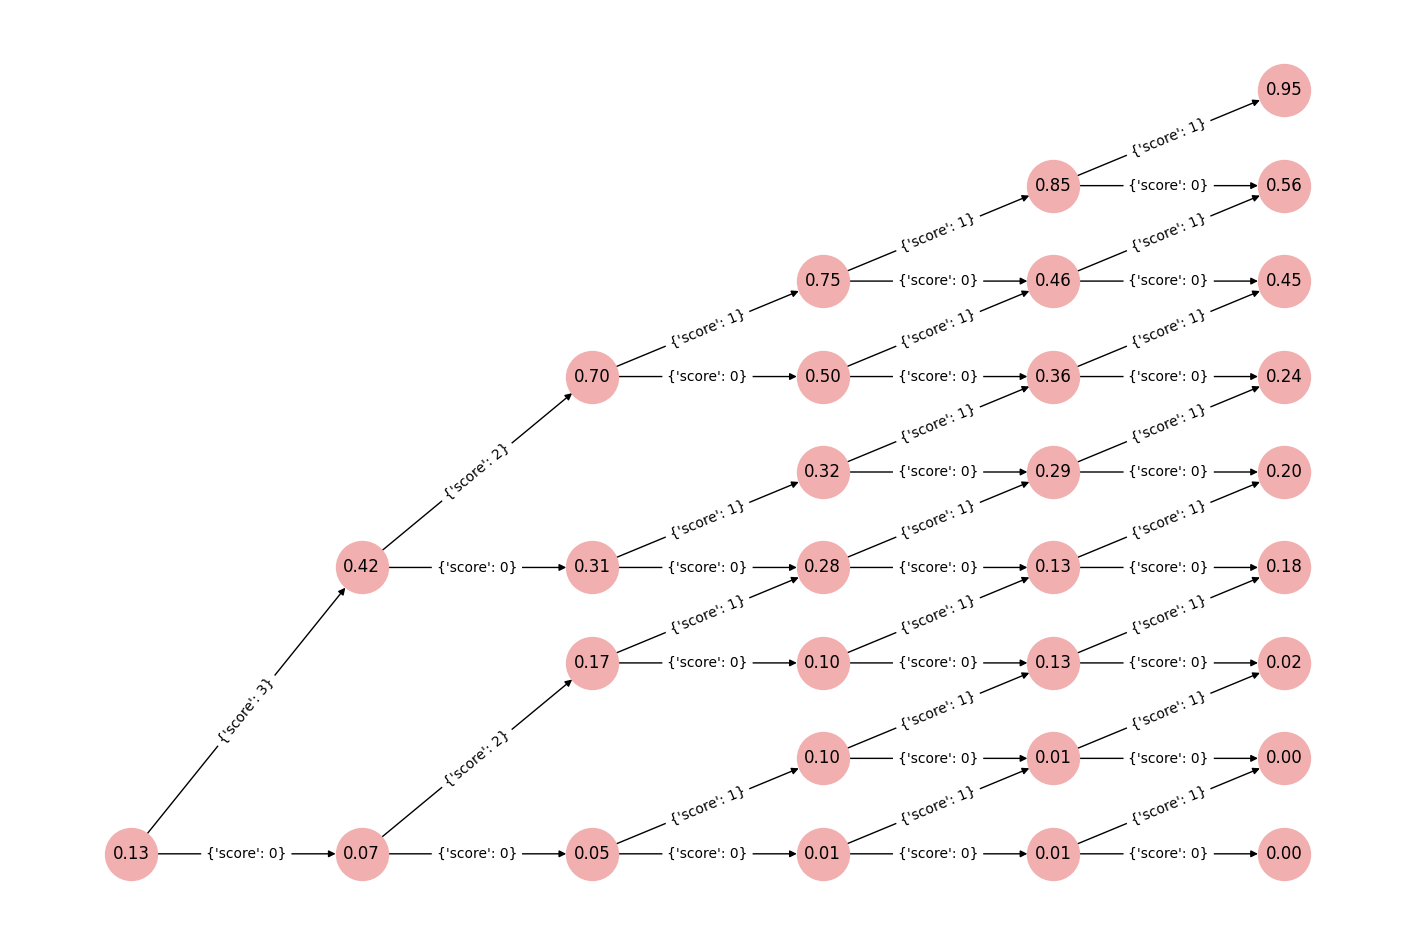

In [199]:
from matplotlib import figure

dag = create_dag(psl_short)
pos = {x:x for x in dag.nodes}
fig, ax = plt.subplots()
fig.set_size_inches(18,12)
node_labels = {
    node: f"{dag.nodes[node]['proba']:.2f}"
    for node in dag.nodes}
nx.draw(dag, pos, with_labels = False,ax=ax, node_size=1400, node_color="#F1AFAF")
nx.draw_networkx_labels(dag, pos, node_labels)
nx.draw_networkx_edge_labels(dag,pos=pos)

In [239]:
from scipy.stats import entropy
from collections import defaultdict
import numpy as np

def expected_loss(y_prob,m=10):
    ub = y_prob[:,1].item()
    y_decision = 1 - ub < m * ub
    loss = (1 - ub) * 1 if y_decision else ub * 10
    return loss


In [240]:
k = 0.12
decision_threshold = 1/11
wloss_lower_confidence = decision_threshold  - decision_threshold * k
wloss_upper_confidence = decision_threshold + (1 - decision_threshold) * k 

print(wloss_lower_confidence, wloss_upper_confidence)

0.08 0.2


In [241]:
per_instance_budget = 3
ci = 0.5
overall_budget = per_instance_budget * len(y_test)
# Predictions when always evaluation the same amount of features per instance
y_prob_non_adaptive = pipeline.predict_proba(X_test, k=per_instance_budget, ci=ci)


# Instantiate dag for heuristic
dag = create_dag(psl=psl)
y_prob_adaptive = []
remaining_budget = overall_budget
imputer = pipeline[0]
psl = pipeline[1]

X_test = imputer.transform(X_test)

for x_test in X_test:
    x_test = x_test.reshape(1,-1)    
    stage = 0
    current_score = int(psl[stage]._compute_total_scores(
            x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
        ).item())
    current_proba = psl.predict_proba(x_test, k=stage, ci=0.5).squeeze()

    while wloss_lower_confidence < current_proba[2] < wloss_upper_confidence and remaining_budget > 0 and stage+1 < len(psl):
        stage += 1
        # current_score = psl[stage]._compute_total_scores(
        #         x_test, psl[stage].features, psl[stage].scores_, psl[stage].feature_thresholds
        #     ).item()
        current_proba = psl.predict_proba(x_test, k=stage, ci=0.5).squeeze()
        remaining_budget -= 1
    y_prob_adaptive.append(current_proba)
y_prob_adaptive = np.stack(y_prob_adaptive)

In [242]:
stage

1

In [243]:
cwloss_adap = conservative_weighted_loss(y_test, y_prob_adaptive)
cwloss_non_adap = conservative_weighted_loss(y_test, y_prob_non_adaptive)


[[0.7275 0.09  ]
 [0.095  0.0875]]
[[0.345  0.4725]
 [0.01   0.1725]]


In [244]:
print("non adaptive:", cwloss_non_adap)
print("adaptive:", cwloss_adap)

non adaptive: 0.5725
adaptive: 1.04


In [245]:
remaining_budget

800

In [246]:
import pandas as pd
df = pd.read_csv("experiments/results/cost_results_naive.csv")

<Axes: xlabel='method', ylabel='cwloss'>

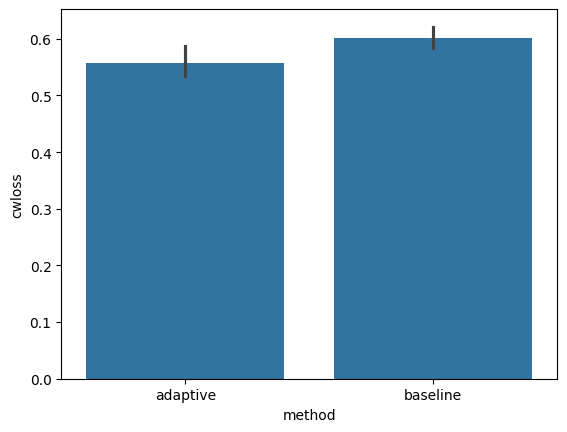

In [247]:
sns.barplot(df,x="method", y="cwloss")